### Dataset
Набор данных является частью коллекции AG News. Он содержит 4 класса:  
1. "World News"  
2. "Sports News"  
3. "Business News"  
4. "Science-Technology News".  

Каждый класс содержит 30 000 обучающих выборок и 1900 тестовых выборок. Общее количество обучающих выборок составляет 120 000, а тестовых - 7600. Задача классификация текста.

### Columns description
- Class Index - содержит ID класса, к которому принадлежат новости
- Title - заголовок статьи
- Description - сама новостная статья    

https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string  

%matplotlib inline

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

import warnings 
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('D:\Data/train_nlp.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [4]:
data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
data.columns = ['ID', 'Title', 'Description']

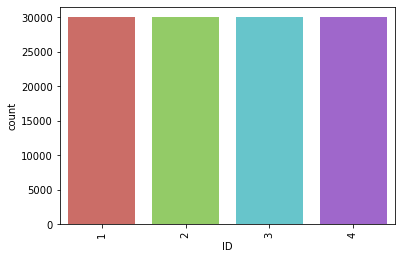

In [6]:
sns.countplot(x = data['ID'], data=data, palette='hls') # посмотрим балансировку классов
plt.xticks(rotation=90)
plt.show()

Для анализа объединим столбцы Title и Description. Для дальнейшей работы возьмем для train первые 96 000 строк, для test следующие 24 000 строк. Итого разделили выборку на 80/20.

In [7]:
train_x = data['Title'] + " " + data['Description'] 
train_y = data['ID']   
train_x = train_x[:96000]                             
train_y = train_y[:96000]

test_x = data['Title'] + " " + data['Description']
test_y = data['ID']
test_x = test_x[96001:120000]                          
test_y = test_y[96001:120000]

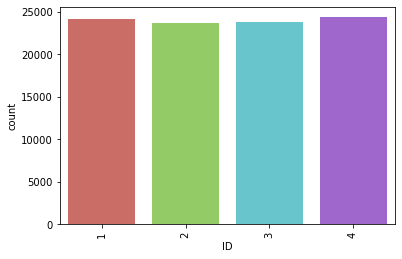

In [8]:
sns.countplot(x = train_y, data=data, palette='hls') # посмотрим балансировку классов после разделения
plt.xticks(rotation=90)
plt.show()

Построим облака слов для каждого класса и проанализируем полученный результат:

(-0.5, 599.5, 399.5, -0.5)

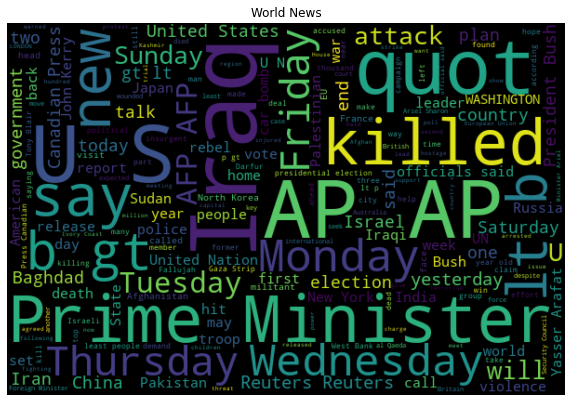

In [9]:
World_News = data[data['ID']==1]
World_News = World_News['Title'] + " " + World_News['Description'] 
all_words = ' '.join([word for word in World_News])   

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('World News')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

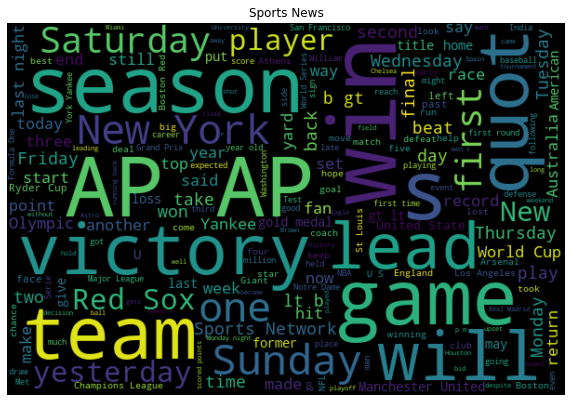

In [10]:
Sports = data[data['ID']==2]
Sports = Sports['Title'] + " " + Sports['Description'] 
all_words = ' '.join([word for word in Sports])   

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Sports News')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

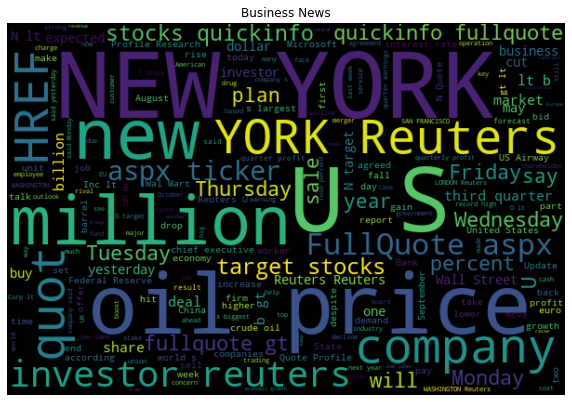

In [11]:
Business = data[data['ID']==3]
Business = Business['Title'] + " " + Business['Description'] 
all_words = ' '.join([word for word in Business])   

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Business News')
plt.axis('off')

(-0.5, 599.5, 399.5, -0.5)

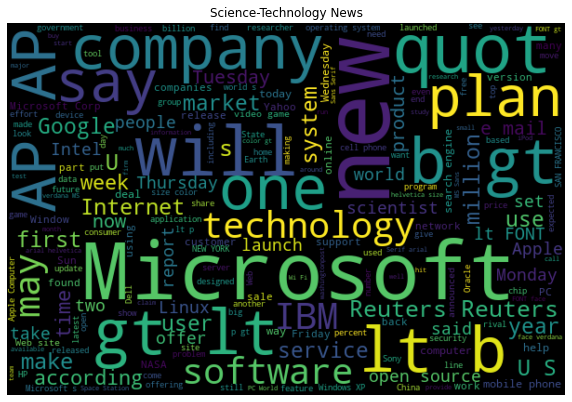

In [12]:
Science = data[data['ID']==4]
Science = Science['Title'] + " " + Science['Description'] 
all_words = ' '.join([word for word in Science])    # построим облако слов

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Science-Technology News')
plt.axis('off')

Уже на этом этапе можно заметить, что есть "спицифические" слова, присущие только одному классу новостей. 
Можно заметить, что датасет содержит много повторяющихся слов, таких как дни недели. Возможно, что есть подкласс спортивных новостей (например спортивные матчи), которые происходят в выходные дни или, например, заключение бизнес контрактов наоборот осуществляется только в рабочие дни.

### Preprocessing


In [13]:
def tokenization(text):  # токенизация
    lst = text.split()
    return lst

train_x = train_x.apply(tokenization)
test_x = test_x.apply(tokenization)

In [14]:
def lowercasing(lst):    # пусть все слова будут в нижнем регистре
    new_lst=[]
    for i in lst:
        i = i.lower()
        new_lst.append(i) 
    return new_lst

train_x = train_x.apply(lowercasing)
test_x = test_x.apply(lowercasing)

In [15]:
def remove_punctuations(lst):       # убираем пунктуацию
    new_lst=[]
    for i in lst:
        for j in string.punctuation:
            i = i.replace(j, '')
        new_lst.append(i)
    return new_lst

train_x = train_x.apply(remove_punctuations) 
test_x = test_x.apply(remove_punctuations)

In [16]:
def remove_numbers(lst):  # убираем цифры
    nodig_lst = []
    new_lst = []

    for i in lst:
        for j in string.digits:
            i = i.replace(j, '')
        nodig_lst.append(i)
    for i in nodig_lst:
        if i != '':
            new_lst.append(i)
    return new_lst

train_x = train_x.apply(remove_numbers)
test_x = test_x.apply(remove_numbers)

In [17]:
def remove_stopwords(lst):              # очистим от стоп-слов
    stop = stopwords.words('english')
    new_lst = []
    for i in lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)  

### Lemmatization and stemming  
Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме. Например, в русском языке нормальными формами считаются следующие морфологические формы:  

для существительных — именительный падеж, единственное число;  
для прилагательных — именительный падеж, единственное число, мужской род;  
для глаголов, причастий, деепричастий — глагол в инфинитиве (неопределённой форме) несовершенного вида.  

Сте́мминг (англ. stemming — находить происхождение) — это процесс нахождения основы слова для заданного исходного слова. Основа слова не обязательно совпадает с морфологическим корнем слова.  

https://ru.wikipedia.org/wiki/Лемматизация  
https://ru.wikipedia.org/wiki/Стемминг

In [18]:
#nltk.download('wordnet')

In [19]:
#lemmatizer = WordNetLemmatizer()      # F1 score:  0.6530, Accuracy:  0.6560
#def lemmatzation(lst):
#    new_lst = []
#    for i in lst:
#        i = lemmatizer.lemmatize(i)
#        new_lst.append(i)
#    return new_lst

#train_x = train_x.apply(lemmatzation)
#test_x = test_x.apply(lemmatzation)

In [20]:
stemmer = SnowballStemmer("english")  # F1 score:  0.9072, Accuracy:  0.9075

def stemming(lst):
    new_lst = []
    for i in lst:
        i = stemmer.stem(i)
        new_lst.append(i)
    return new_lst

train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)

### TF-IDF  
TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.  
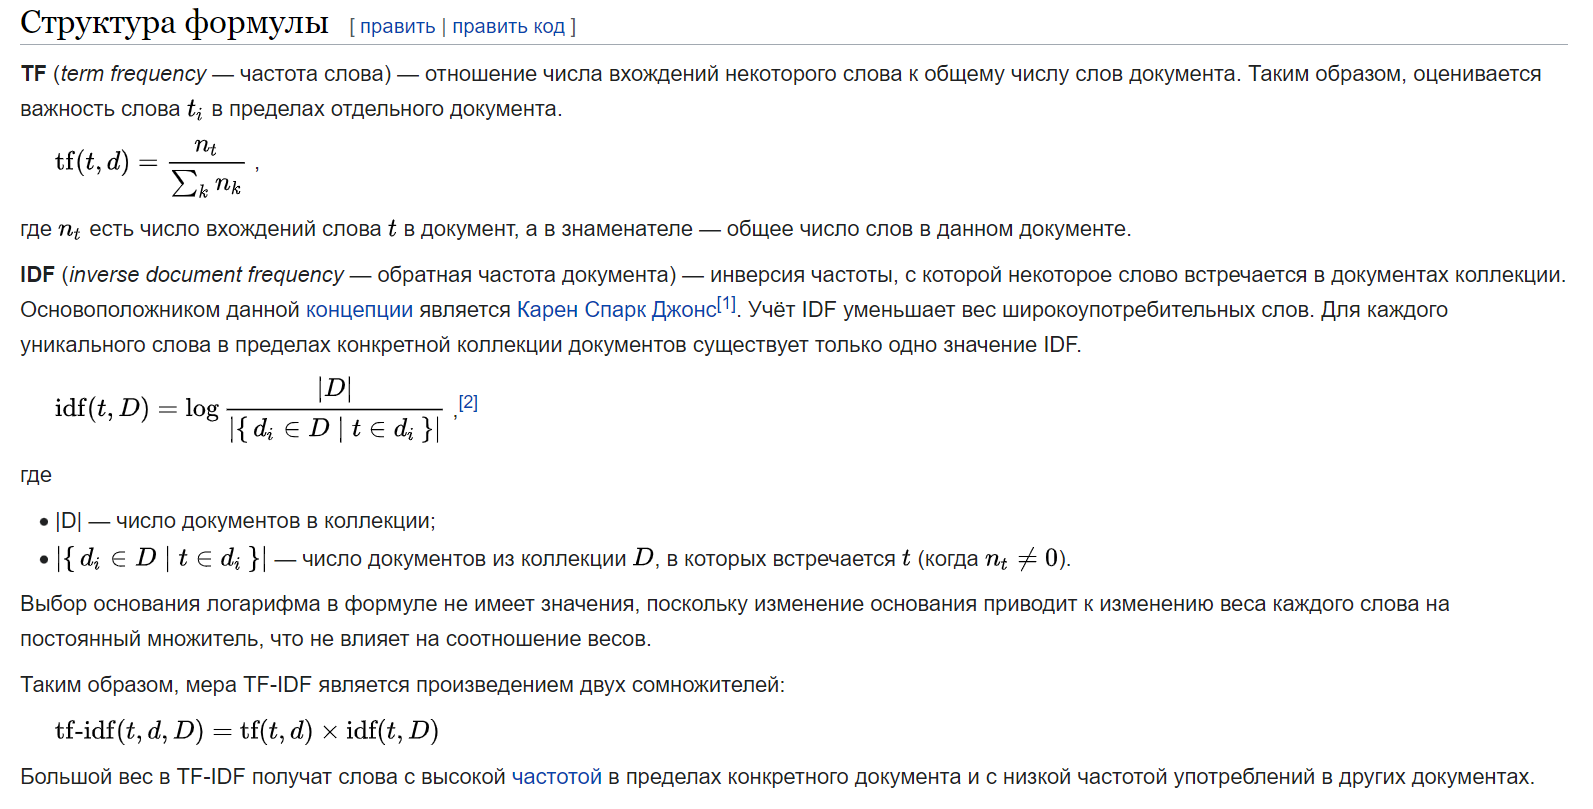

https://ru.wikipedia.org/wiki/TF-IDF

In [21]:
train_x = [" ".join(map(str, lst)) for lst in train_x]
test_x = [" ".join(map(str, lst)) for lst in test_x]

In [22]:
TfIdf = TfidfVectorizer (ngram_range=(1,2), min_df = 6)
# min_df= минимальное кол-во документов, в которых должно встретиться слово, чтобы оно было включено в словарь;
# ngram_range=(1,2) в качестве признаков могут использоваться отдельные слова (униграммы) и пары слов (биграммы)

train_1 = TfIdf.fit_transform(train_x)
test_1 = TfIdf.transform(test_x)

print("Features extracted: ")
print(len(TfIdf.get_feature_names()))
print(TfIdf.get_feature_names()[:100])

Features extracted: 
65956
['aa', 'aa billion', 'aaa', 'aapl', 'aapl news', 'aaron', 'aaron babe', 'aaron boon', 'aaron peirsol', 'aaron rodger', 'ab', 'ababa', 'ababa ethiopia', 'abandon', 'abandon cds', 'abandon copycontrol', 'abandon microsoft', 'abandon nuclear', 'abandon plan', 'abarrel', 'abarrel mark', 'abat', 'abba', 'abbey', 'abbey bid', 'abbey nation', 'abbi', 'abbi wambach', 'abbott', 'abbott laboratori', 'abc', 'abc apolog', 'abc news', 'abdic', 'abduct', 'abduct baghdad', 'abduct cnn', 'abduct gunpoint', 'abduct iraq', 'abduct kill', 'abduct six', 'abduct three', 'abduct two', 'abductor', 'abdul', 'abdul kalam', 'abdullah', 'abdullah ahmad', 'abdullah badawi', 'abdullah ii', 'abdullahi', 'abdullahi yusuf', 'abercrombi', 'aberdeen', 'abid', 'abidjan', 'abidjan ivori', 'abidjan reuter', 'abil', 'abil make', 'abil run', 'abimael', 'abimael guzman', 'abkhazia', 'abl', 'abl access', 'abl buy', 'abl check', 'abl get', 'abl log', 'abl make', 'abl pitch', 'abl play', 'abl see', 'a

## Classical Machine Learning Model  
SGDClassifier — это модель логистической регрессии со стохастическим градиентным спуском (для подсчета градиента ошибки на каждом шаге берется некоторое подмножество от общего количества объектов). За счет этого скорость обучения модели машинного обучения сильно сокращается, а итоговое качество мало отличается от полноценного классификатора.  
Она успешно применяется для решения крупномасштабных и разреженных задач машинного обучения, часто встречающихся при классификации текста и обработке естественного языка. 

In [23]:
train_1.shape

(96000, 65956)

In [24]:
test_1.shape

(23999, 65956)

In [25]:
SGDClass = SGDClassifier(max_iter = 500, alpha = 1e-6, loss='log', random_state=70)
SGDClass.fit(train_1,train_y)
pred_cl = SGDClass.predict(test_1)
acc_cl = accuracy_score(test_y,pred_cl)
conf_cl = confusion_matrix(test_y,pred_cl)

In [26]:
print('Accuracy: ', acc_cl)
print('Confusion_matrix: \n', conf_cl)

Accuracy:  0.9105796074836452
Confusion_matrix: 
 [[5216  130  245  235]
 [  60 6149   47   40]
 [ 192   58 5366  624]
 [ 171   38  306 5122]]


In [27]:
f1_cl = f1_score(test_y, pred_cl, average='weighted')
print('F1 score: ', f1_cl)

F1 score:  0.910553817231439


# Выводы: 
В ходе выполнения работы по классификации текста были получены следующие результаты:
1) Лемматизация показала себя менее эффективной: F1 score 0.6530, Accuracy 0.6560  
2) Стемминг привел к значительно более высоким результатам: F1 score 0.9072, Accuracy 0.9075. Такой результат может быть достигнут благодаря тому, что стемминг применяет более простой подход к обработке текста, удаляя суффиксы и основываясь на простых, но эффективных правилах, в отличии от лемматизации.  
3) Далее была выполнена настройка параметров метода TF-IDF, оптимальными являются следующие параметры: ngram_range=(1,2), min_df = 6. Этот метод эффективно выделяет значимые слова в тексте.  
4) Была выбрана модель SGDClassifier, по причине того, что она учитывает специфику обработки данных для NLP и имеет высокую скорость. Подбирая в ручную гиперпараметры модели удалось повысить результат до: F1 score 0.9106, Accuracy 0.9106